In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

In [2]:
basepath = ['/Users/blandt/Desktop/Data/PAR2 RING mutants experiment 2/Experiment',
            '/Users/blandt/Desktop/Data/PAR2 RING mutants experiment 2/N2']
paths = direcslist(basepath, 1)

imgs = [load_image(p + '/af_corrected.tif') for p in paths]
imgs_flat = [load_image(p + '/af_corrected_flat.tif') for p in paths]
imgs_3channel = [load_image(p + '/af_corrected_3channel.tif') for p in paths]
imgs_3channel_flat = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths]

rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]
cytbg = np.loadtxt('../T2A/cytbg.txt')
membg = np.loadtxt('mem_profile.txt')

In [3]:
iq = ImageQuant(img=imgs, cytbg=cytbg, membg=membg, roi=rois, uni_cyt=False, descent_steps=500, 
                rol_ave=5, lr=0.01, iterations=1, interp_type='linear')
iq.run()

100%|██████████| 500/500 [02:10<00:00,  3.84it/s]


Time elapsed: 133.16 seconds 


<IPython.core.display.Javascript object>


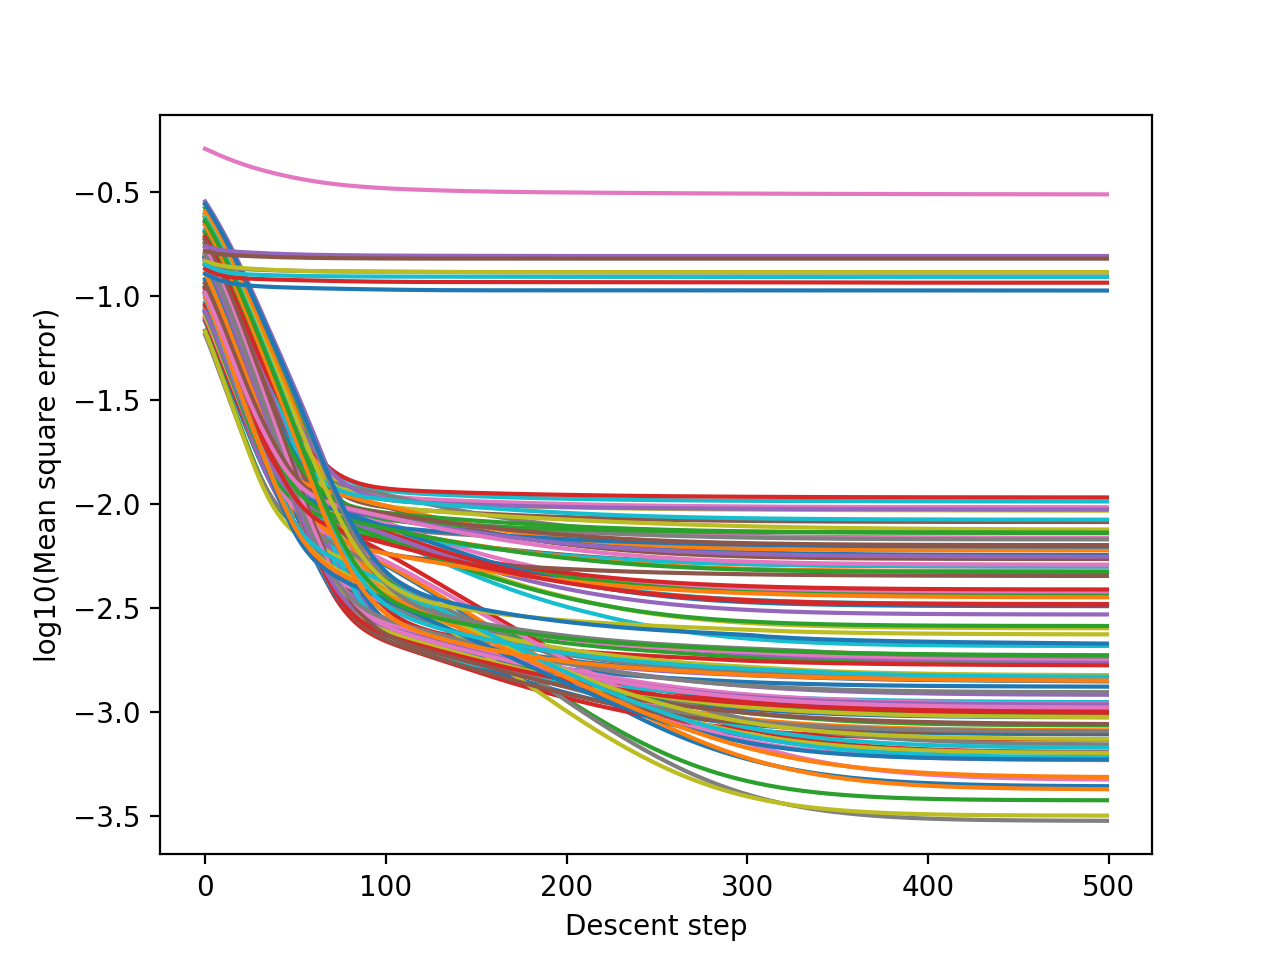

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [9]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


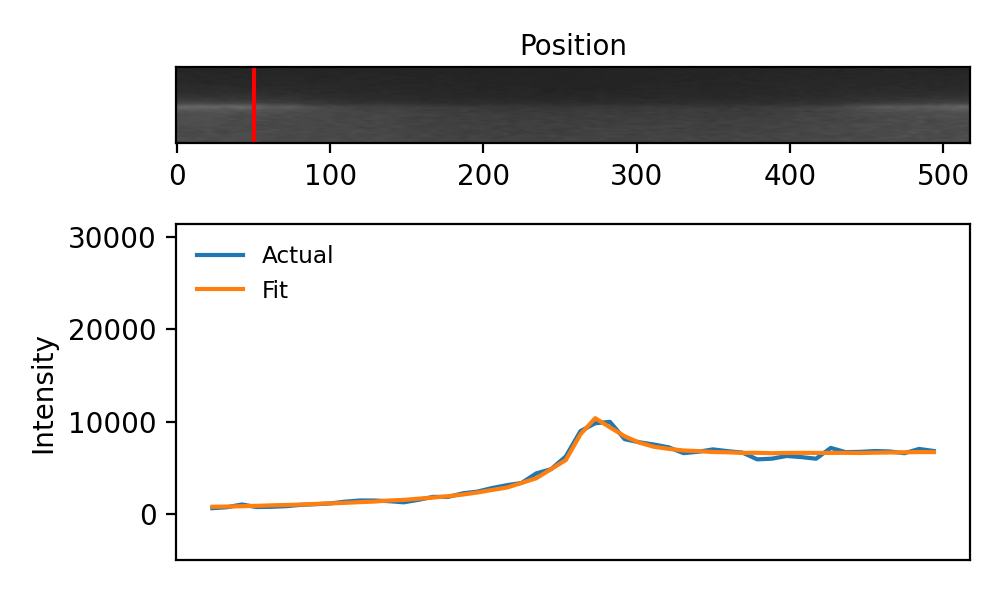

interactive(children=(IntSlider(value=0, description='Frame'), FloatSlider(value=0.1, description='Position', …

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [10]:
iq.plot_fits(jupyter=True)

<IPython.core.display.Javascript object>


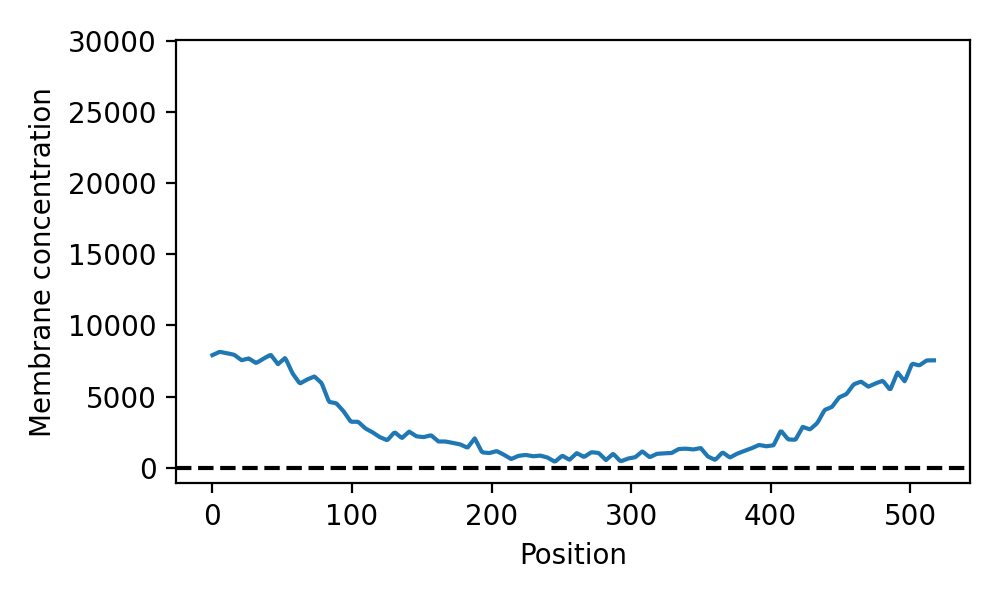

interactive(children=(IntSlider(value=0, description='Frame'), Output()), _dom_classes=('widget-interact',))

(<Figure size 500x300 with 1 Axes>,
 <AxesSubplot:xlabel='Position', ylabel='Membrane concentration'>)

In [11]:
iq.plot_quantification(jupyter=True)

### Compile results

In [12]:
res = iq.compile_res()
res['Membrane signal'] = res['Membrane signal'] * 2.8893596260583494
res.to_csv('res.csv')

In [14]:
res = pd.read_csv('res.csv')
lines = [p.split('/')[-2].split('_')[1] for p in paths]
line_to_genotype = {'nwg351': 'L50R + L109R' , 'nwg338': 'L109R' , 'nwg240bal': 'C56S bal', 'n2': 'N2', 
                    'nwg400': 'L50R', 'nwg400bal': 'L50R bal', 'nwg240': 'C56S', 'nwg325bal': 'Wild type bal', 
                    'nwg407': 'C56S + L109R', 'nwg325': 'Wild type', 'nwg338bal': 'L109R bal'}
genotypes = [line_to_genotype[l] for l in lines]

mems_tot = res.groupby('Frame').apply(lambda x: np.mean(x['Membrane signal']))
mems = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.9, 0.1)))
cyts = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], (0.9, 0.1)))
ratios = [m / c for m, c in zip(mems, cyts)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
totals = cyts + 0.174 * mems_tot

df = pd.DataFrame.from_dict({'Path': paths, 'Line': lines, 'Genotype': genotypes, 'Membrane': mems, 
                              'Cytoplasm': cyts, 'Ratio': ratios, 'Dosage': dosages, 'Total': totals})
df.to_csv('df.csv')